# Stock prediction using Long short-term memory 

An LSTM is a type of recurrent neural network that addresses the vanishing gradient problem in traditional RNNs. By using a gating mechanism that selectively recalls or forgets information, LSTM networks deal with this problem. In essence, LSTM uses past data in a particular way. It uses data that the neural network has seen and 'forgets' irrelevant data.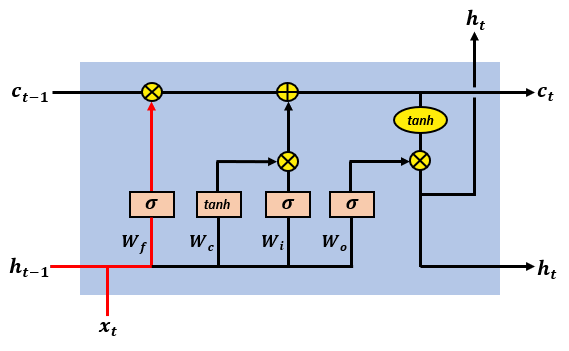


Some of its most common uses are:
- language modeling, such as translation, and 
- time series forecasting such as predicting weather, energy consumption and **stock prices**!

In [1]:
#import libraries

import yfinance as yf
import pandas as pd
import datetime as datetime
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import classification_report
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt


import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# from dash import dash, dcc, html, Input, Output

Get past5 years of stock data 

In [2]:
# get today's date
end_date = datetime.datetime.today().strftime("%Y-%m-%d")

#we will train our model individually on three different stocks 
tickers = ["AAPL", "MSFT", "AMZN"]

# get past 5 years of data
start_date = (datetime.datetime.today() - datetime.timedelta(days=365*5)).strftime("%Y-%m-%d")
stock_data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  3 of 3 completed


Keep only values for close and reorganize dataframe

In [3]:
stock_data_close = stock_data['Close']

In [4]:
stock_data_close

,AAPL,AMZN,MSFT
Date,,,
2018-08-27 00:00:00-04:00,54.485001,96.384003,109.599998
2018-08-28 00:00:00-04:00,54.924999,96.640999,110.260002
2018-08-29 00:00:00-04:00,55.744999,99.904999,112.019997
2018-08-30 00:00:00-04:00,56.257500,100.119003,111.949997
2018-08-31 00:00:00-04:00,56.907501,100.635498,112.330002
...,...,...,...
2023-08-18 00:00:00-04:00,174.490005,133.220001,316.480011
2023-08-21 00:00:00-04:00,175.839996,134.679993,321.880005
2023-08-22 00:00:00-04:00,177.229996,134.250000,322.459991


Split data now in train and test.<br>We will use a standard 80/20 split

In [5]:
data_split = int(stock_data_close.shape[0] * 0.8)

df_train, df_test = stock_data_close[:data_split], stock_data_close[data_split:]

Scale data to speed up conversion in the model

In [6]:
scaled_df_train = {}
scaled_df_test = {}
train_scaler = {}
test_scaler = {}

for i in tickers:
    min_maxscaler = MinMaxScaler(feature_range=(0,1))
    scaled_df_train[i] = min_maxscaler.fit_transform(df_train[[i]])
    train_scaler[i] = min_maxscaler
    
for i in tickers:
    min_maxscaler = MinMaxScaler(feature_range=(0,1))
    scaled_df_test[i] = min_maxscaler.fit_transform(df_test[[i]])
    test_scaler[i] = min_maxscaler

Now, we will use the previous 60 trading days to train the model

In [7]:
#train data

train = {}
for stock in df_train.columns:
    #dict inside dict for each stock to have x and y values
    train[stock] = {}
    x_train = []
    y_train = []
    for i in range(60, len(scaled_df_train[stock])):
        x_train.append(scaled_df_train[stock][i-60:i,0])
        y_train.append(scaled_df_train[stock][i,0])
    #convert list into array
    x_train, y_train = np.array(x_train), np.array(y_train)
    #reshape data
    train[stock]['X'] = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    train[stock]['y'] = y_train

    
#test data

test = {}
for stock in df_test.columns:
    test[stock] = {}
    x_test = []
    y_test = []
    for i in range(60, len(scaled_df_test[stock])):
        x_test.append(scaled_df_test[stock][i-60:i,0])
        y_test.append(scaled_df_test[stock][i,0])
    #convert list into array
    x_test, y_test = np.array(x_test), np.array(y_test)
    #reshape data
    test[stock]['X'] = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    test[stock]['y'] = y_test

Now we can start building our model

Build LSTM Model

In [22]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
lstm_model = Sequential()
#no layers 
lstm_model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences = False))
#no neurons
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

#compile model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

Fit model

In [25]:
for i in tickers:
    lstm_model.fit(train[i]['X'], train[i]['y'], batch_size=32, epochs=100, callbacks=[early_stop])

Epoch 1/100
30/30 [==============================] - 3s 44ms/step - loss: 5.8901e-04
Epoch 2/100
30/30 [==============================] - 1s 42ms/step - loss: 4.4626e-04
Epoch 3/100
30/30 [==============================] - 1s 41ms/step - loss: 4.3827e-04
Epoch 4/100
30/30 [==============================] - 1s 42ms/step - loss: 4.3567e-04
Epoch 5/100
30/30 [==============================] - 1s 43ms/step - loss: 4.2494e-04
Epoch 6/100
30/30 [==============================] - 1s 42ms/step - loss: 4.2581e-04
Epoch 7/100
30/30 [==============================] - 1s 44ms/step - loss: 4.3373e-04
Epoch 8/100
30/30 [==============================] - 1s 43ms/step - loss: 4.1945e-04
Epoch 9/100
30/30 [==============================] - 1s 42ms/step - loss: 4.1749e-04
Epoch 10/100
30/30 [==============================] - 1s 44ms/step - loss: 4.2803e-04
Epoch 11/100
30/30 [==============================] - 1s 46ms/step - loss: 4.1567e-04
Epoch 12/100
30/30 [==============================] - 1s 41ms/s

Epoch 43/100
30/30 [==============================] - 1s 43ms/step - loss: 6.4669e-04
Epoch 44/100
30/30 [==============================] - 1s 44ms/step - loss: 6.4494e-04
Epoch 45/100
30/30 [==============================] - 1s 45ms/step - loss: 7.1006e-04
Epoch 46/100
30/30 [==============================] - 1s 42ms/step - loss: 6.5128e-04
Epoch 46: early stopping


Get predicted prices

In [26]:
for i in tickers:    
    scaled_predictions = lstm_model.predict(test[i]['X'])
    y_hat = test_scaler[i].inverse_transform(scaled_predictions)
    y = test_scaler[i].inverse_transform(test[i]['y'].reshape(-1,1))
    rmse = sqrt(MSE(y_hat, y))
    
    
    #visualization
    df_y_hat = pd.DataFrame(y_hat)
    df_y_hat.columns = [i]
    df_y_hat['date'] = stock_data_close[-len(y_hat):].index
    
    df_y = pd.DataFrame(y)
    df_y.columns = [i]
    df_y['date'] = stock_data_close[-len(y_hat):].index
    
    
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x= df_y['date'],
            y = df_y[i],
            name= 'Real Stock Prices',
            line=dict(color='blue', width=0.7)))

    # add predicted stock prices
    fig.add_trace(
        go.Scatter(
        x = df_y_hat['date'],
        y = df_y_hat[i],
        name = 'Predicted Stock Prices',
        mode ='lines',
        line = dict(color='red', width=1.5)))


    fig.update_layout(
            title= 'Real Stock Prices vs Predicted by LSTM\n\nRMSE {}'.format(rmse),
            xaxis_title = "Date", 
            yaxis_title = 'Value')
    
    fig.show()
    

6/6 [==============================] - 0s 18ms/step


6/6 [==============================] - 0s 19ms/step


6/6 [==============================] - 0s 18ms/step


Predict prices for next 30 days

In [27]:
#plot